# Binary Classification with a Software Defects Dataset


## 0) Intro -  Objective 


Main Goal: Predict defects in C programs given various various attributes about the code.

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.

## 1) Import of packages

In [24]:
import numpy as np # linear algebra
import optuna
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.linear_model import ElasticNet,SGDRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.kernel_approximation import Nystroem
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report


from catboost import CatBoostClassifier

from sklearn.model_selection import GridSearchCV
from feature_engine.encoding import OneHotEncoder
pd.set_option('mode.chained_assignment', None)


import os
for dirname, _, filenames in os.walk('data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


pd.set_option('display.max_rows', None)

#!pip install -U seaborn

data/test.csv
data/train.csv


## 1) Load the data and check structure

In [2]:
train_data = pd.read_csv("data/train.csv", index_col='id')
test_data = pd.read_csv("data/test.csv", index_col='id')

In [3]:
train_data.head()


,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount,defects
id,,,,,,,,,,,,,,,,,,,,,
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,17,1,1,0,16.0,9.0,38.0,22.0,5.0,False
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,11,0,1,0,11.0,11.0,18.0,14.0,3.0,False
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,8,0,1,0,12.0,11.0,28.0,17.0,3.0,False
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,...,4,0,2,0,8.0,6.0,16.0,7.0,1.0,True
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,...,7,0,2,0,7.0,6.0,10.0,10.0,3.0,False


In [4]:
train_data.shape

(101763, 22)

#### All numerical variables

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101763 entries, 0 to 101762
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   loc                101763 non-null  float64
 1   v(g)               101763 non-null  float64
 2   ev(g)              101763 non-null  float64
 3   iv(g)              101763 non-null  float64
 4   n                  101763 non-null  float64
 5   v                  101763 non-null  float64
 6   l                  101763 non-null  float64
 7   d                  101763 non-null  float64
 8   i                  101763 non-null  float64
 9   e                  101763 non-null  float64
 10  b                  101763 non-null  float64
 11  t                  101763 non-null  float64
 12  lOCode             101763 non-null  int64  
 13  lOComment          101763 non-null  int64  
 14  lOBlank            101763 non-null  int64  
 15  locCodeAndComment  101763 non-null  int64  
 16  un

As explained in the original data :https://www.kaggle.com/datasets/semustafacevik/software-defect-prediction
Number of attributes: 22 (5 different lines of code measure,
3 McCabe metrics, 4 base Halstead measures, 8 derived
Halstead measures, a branch-count, and 1 goal field)

Attribute Information:
  1. loc             : numeric % McCabe's line count of code
  2. v(g)            : numeric % McCabe "cyclomatic complexity"
  3. ev(g)           : numeric % McCabe "essential complexity"
  4. iv(g)           : numeric % McCabe "design complexity"
  5. n               : numeric % Halstead total operators + operands
  6. v               : numeric % Halstead "volume"
  7. l               : numeric % Halstead "program length"
  8. d               : numeric % Halstead "difficulty"
  9. i               : numeric % Halstead "intelligence"
 10. e               : numeric % Halstead "effort"
 11. b               : numeric % Halstead 
 12. t               : numeric % Halstead's time estimator
 13. lOCode          : numeric % Halstead's line count
 14. lOComment       : numeric % Halstead's count of lines of comments
 15. lOBlank         : numeric % Halstead's count of blank lines
 16. lOCodeAndComment: numeric
 17. uniq_Op         : numeric % unique operators
 18. uniq_Opnd       : numeric % unique operands
 19. total_Op        : numeric % total operators
 20. total_Opnd      : numeric % total operands
 21: branchCount     : numeric % of the flow graph
 22. defects         : {false,true} % module has/has not one or more  reported defects

 Some of these features are derived from each other. We would usually be able to drop some. However, the synthetic generation process has botched the relationships.

Relationship: t = e / 18. In the original data, the correlation is perfect.

Relationship: l = 1 / d => we can drop l



## 3) Discover and visualize data to gain insights

##### No missing data

In [6]:
train_data.isnull().sum()

loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
defects              0
dtype: int64

In [7]:
test_data.isnull().sum()

loc                  0
v(g)                 0
ev(g)                0
iv(g)                0
n                    0
v                    0
l                    0
d                    0
i                    0
e                    0
b                    0
t                    0
lOCode               0
lOComment            0
lOBlank              0
locCodeAndComment    0
uniq_Op              0
uniq_Opnd            0
total_Op             0
total_Opnd           0
branchCount          0
dtype: int64

In [8]:
train_data.describe()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
count,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,1.017630e+05,...,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000,101763.000000
mean,37.347160,5.492684,2.845022,3.498826,96.655995,538.280956,0.111634,13.681881,27.573007,2.085359e+04,...,1141.357982,22.802453,1.773945,3.979865,0.196604,11.896131,15.596671,57.628116,39.249698,9.839549
std,54.600401,7.900855,4.631262,5.534541,171.147191,1270.791601,0.100096,14.121306,22.856742,1.905714e+05,...,9862.795472,38.541010,5.902412,6.382358,0.998906,6.749549,18.064261,104.537660,71.692309,14.412769
min,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.000000,2.000000,1.000000,1.000000,25.000000,97.670000,0.050000,5.600000,15.560000,5.647300e+02,...,31.380000,7.000000,0.000000,1.000000,0.000000,8.000000,7.000000,15.000000,10.000000,3.000000
50%,22.000000,3.000000,1.000000,2.000000,51.000000,232.790000,0.090000,9.820000,23.360000,2.256230e+03,...,125.400000,14.000000,0.000000,2.000000,0.000000,11.000000,12.000000,30.000000,20.000000,5.000000
75%,42.000000,6.000000,3.000000,4.000000,111.000000,560.250000,0.150000,18.000000,34.340000,1.019324e+04,...,565.920000,26.000000,1.000000,5.000000,0.000000,16.000000,20.000000,66.000000,45.000000,11.000000
max,3442.000000,404.000000,165.000000,402.000000,8441.000000,80843.080000,1.000000,418.200000,569.780000,1.684662e+07,...,935923.390000,2824.000000,344.000000,219.000000,43.000000,410.000000,1026.000000,5420.000000,3021.000000,503.000000


### Plot features distribution

Variables are very skewed, log transformation should be useful to make better predictions

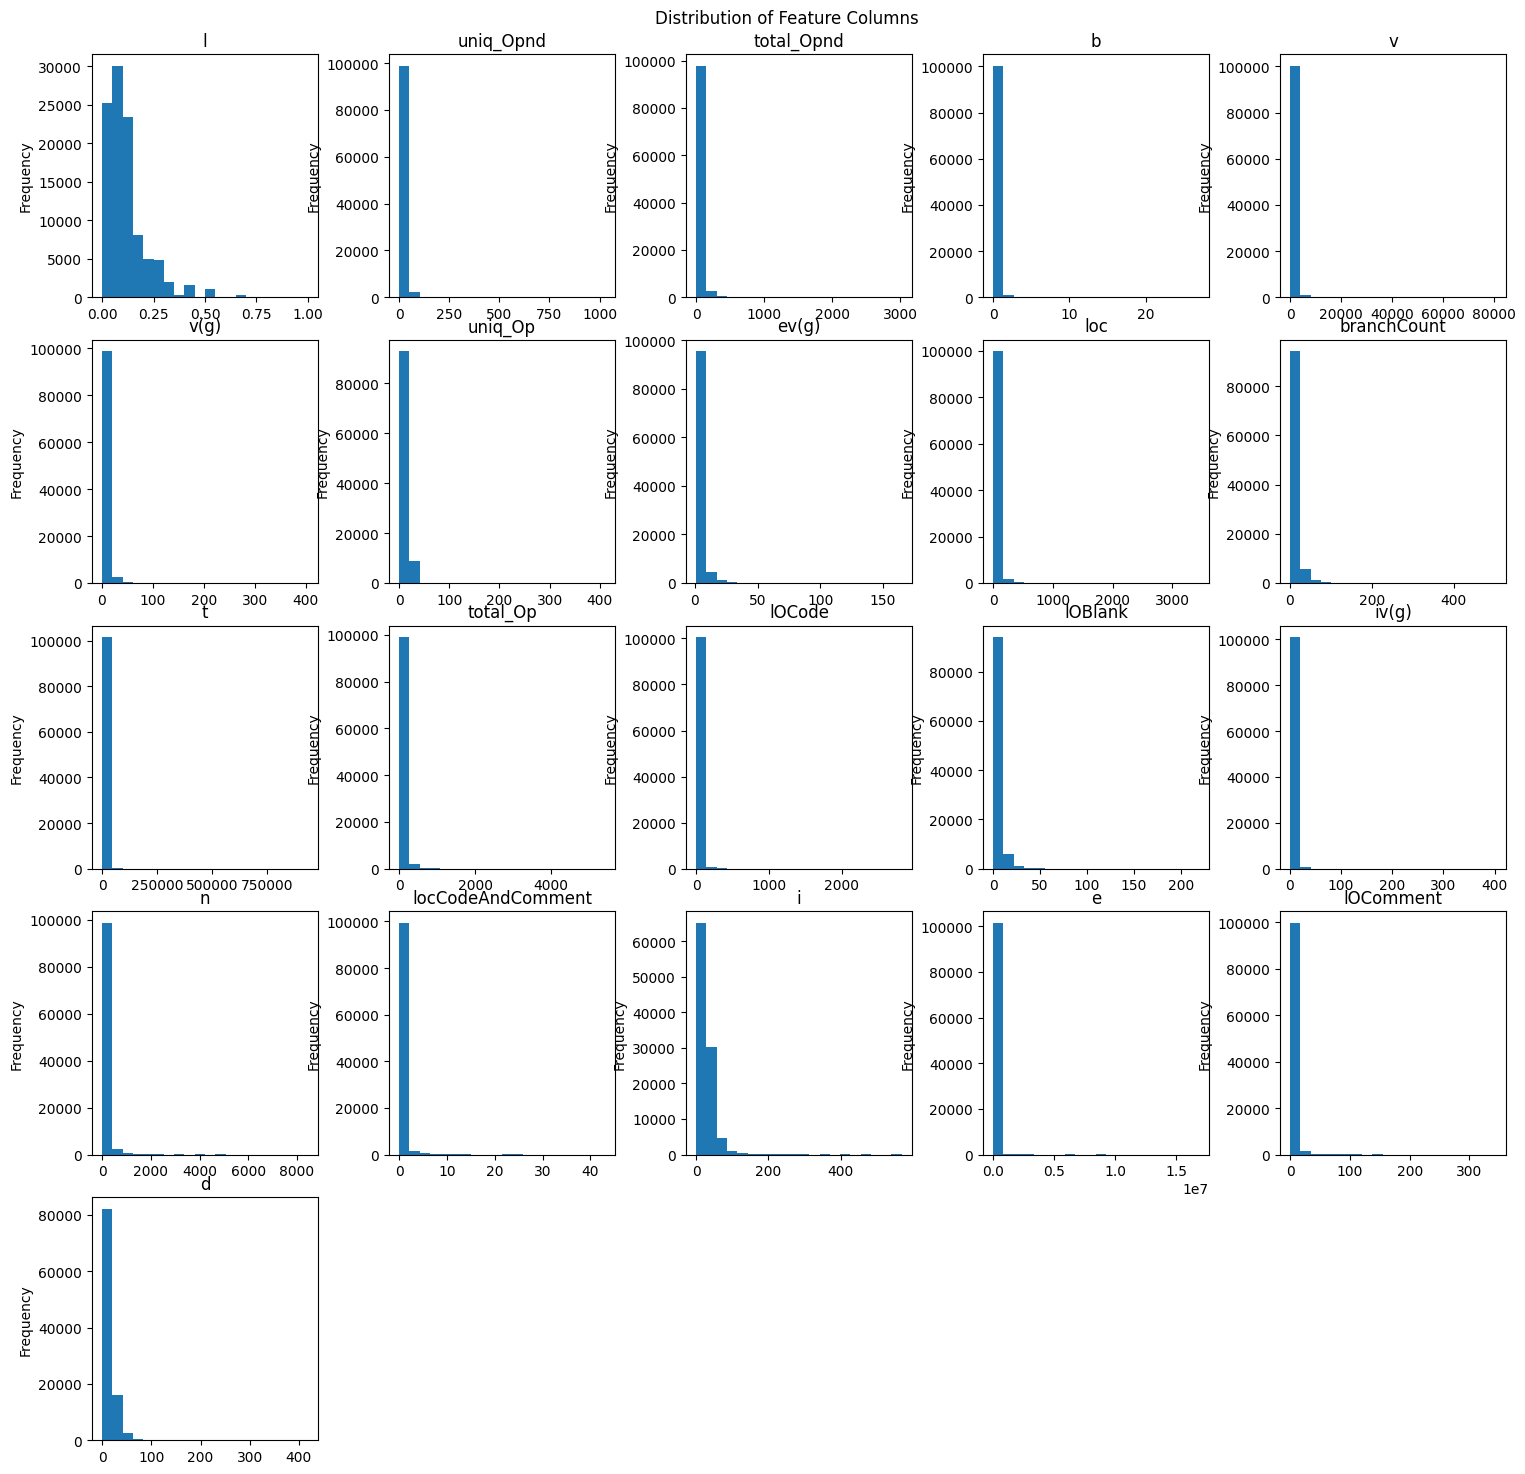

In [9]:
def plot_features_distribution(df):

    feature_columns = set(df.columns)-set(["defects"])

    # Define the number of rows and columns for subplots
    num_rows = (len(feature_columns) + 4) // 5
    num_cols = min(len(feature_columns), 5)

    # Create subplots
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 3 * num_rows))

    fig.subplots_adjust(wspace=0.3, hspace=0.5,top=0.90, bottom=0.3)
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

    # Iterate through feature columns and plot their distributions
    for i, col in enumerate(feature_columns):
        row = i // num_cols
        col_num = i % num_cols
        ax = axes[row, col_num]

        # Plot the distribution
        df[col].plot(kind='hist', ax=ax, bins=20, title=col)
        ax.set_ylabel('Frequency')

    # If there are empty subplots, remove them
    for i in range(len(feature_columns), num_rows * num_cols):
        fig.delaxes(axes.flatten()[i])

    # Add a title to the overall picture
    plt.suptitle("Distribution of Feature Columns")
    # Show the plot
    plt.show()



plot_features_distribution(train_data)


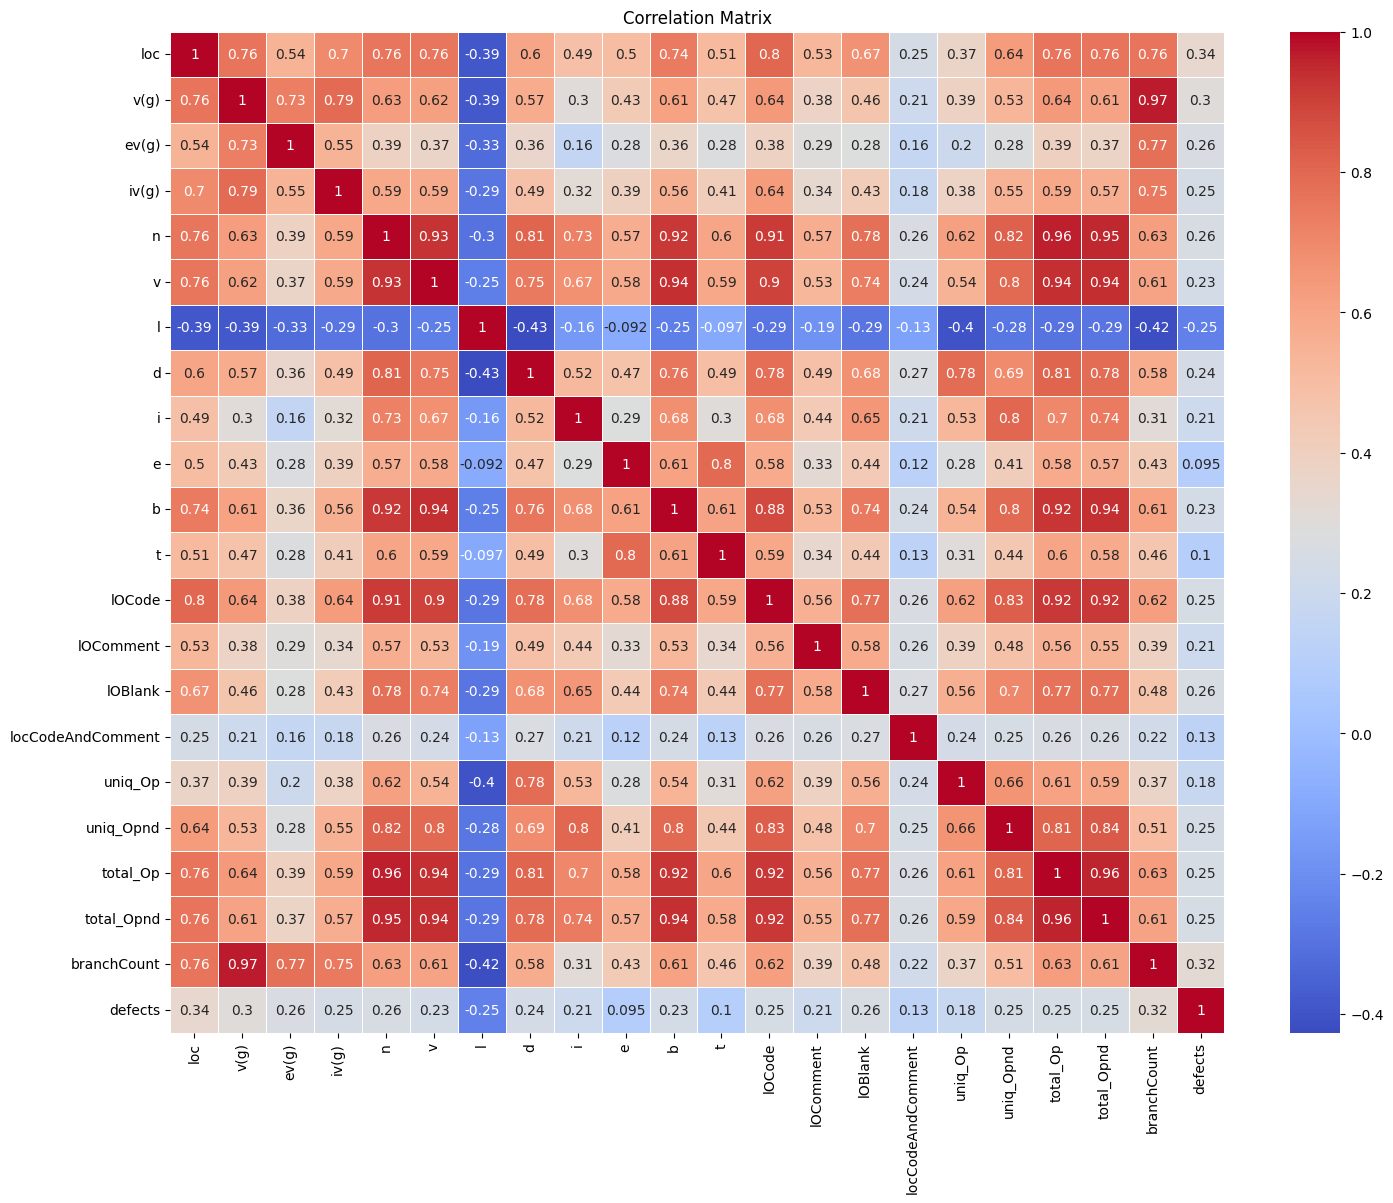

In [10]:
#### Correlation matrix

correlation_matrix = train_data.corr()
plt.figure(figsize=(17, 13))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


#Relationship: t = e / 18. In the original data, the correlation is perfect. => we can drop t
#Relationship: l = 1 / d => we can drop l

## Feature engineering

In [11]:
FEATURES = list(set(train_data.columns)-set(["defects"])-set(["t", "d"]))
TARGET = 'defects'

In [12]:
# from sklearn.preprocessing import MinMaxScaler

# def edit_features(df):
    
#     sqrt_df = np.sqrt(df[FEATURES])
#     log_df =  np.log10(sqrt_df+1)
#     log_df[TARGET] = df[TARGET]

#     # scaler = MinMaxScaler()
#     # scaled_data = scaler.fit_transform(log_df)
#     # scaled_df = pd.DataFrame(scaled_data, columns=log_df.columns,  index=df.index)

#     return log_df

# full_enhanced=  edit_features(full_data.copy())
# plot_features_distribution(full_enhanced)


## Modelling
Split the data into train and validation set, stratify since dataset is unbalanced

In [56]:
y = train_data.copy().defects.astype(int)
X = train_data.copy().drop(['defects'],axis=1)

# Single split
train_X, val_X, train_y, val_y = train_test_split(X,y,stratify=y,test_size=0.1,random_state=0)

### Cross validation strategy

In [34]:
kfold = KFold(n_splits=5,shuffle=True,random_state=0)
skfold = StratifiedKFold(n_splits=5,shuffle=True,random_state=0)

### Logistic regression

In [14]:
from sklearn.linear_model import LogisticRegression

def logistic_predictions(train_X, train_y):

    reg = LogisticRegression()
    
    reg.fit(train_X,train_y)
    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))
    
    return predictions, reg

log_predictions, log_model = logistic_predictions(train_X, train_y)

ROC-AUC score training 0.624536181975267
ROC-AUC score validation 0.6289912640882481


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### XGB Classifier

#### Parameter optimization

In [17]:
OPTUNA = False

if OPTUNA:
    # Use optuna library for optimizing multiple hyper parameters
    def xgb_objective(trial):

        # Set the hyperparameters of the XGBoost classifier.
        params = {'objective':'binary:logistic', 
                  'n_estimators':trial.suggest_int('n_estimators',10,100),
                  'learning_rate':0.04872179246700902, #trial.suggest_float('learning_rate',0.03,0.3)
                  'max_depth':None,
                  'gamma':5,
                  'scale_pos_weight':77.3/22.7,
                  'random_state':0
                 }

        xgb_auc_score_avg = 0
        for idx, (train_idx,val_idx) in enumerate(skfold.split(X,y)):
            train_X = X.iloc[train_idx]
            val_X = X.iloc[val_idx]
            train_y = y[train_idx]
            val_y = y[val_idx]

            xgb_model = xgb.XGBClassifier(**params)

            xgb_model.fit(train_X,train_y)

            xgb_prediction = xgb_model.predict_proba(val_X)[:,1]
            xgb_prediction[xgb_prediction>1]=1
            xgb_prediction[xgb_prediction<0]=0
            xgb_auc_score = roc_auc_score(val_y, xgb_prediction)
            print(f'The AUC score evaluated on the validation subset using XGB model for fold {idx}: ', xgb_auc_score)

            xgb_auc_score_avg += xgb_auc_score
            
        xgb_auc_score_avg /=5
        print(f'The averaged AUC score evaluated on the validation subset using XGB model:', xgb_auc_score_avg)
        return -xgb_auc_score_avg

    xgb_study = optuna.create_study()
    xgb_study.optimize(xgb_objective, n_trials=20)
    best_xgb_params = xgb_study.best_trial.params

    print('Best XGB hyper parameters:', best_xgb_params)

#### Single execution

In [16]:
xgb_params = {'objective':'binary:logistic', 
              'n_estimators':100,
              'learning_rate':0.03858856691681774,
              'max_depth':None,
              'gamma':5,
              'scale_pos_weight':77.3/22.7,
              'random_state':0}

def XGBoost_predictions(train_X, train_y):

    reg = xgb.XGBClassifier(eval_metric  = "mape", **xgb_params
                           )
    
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    return predictions, reg

xgb_predictions, xgb_model = XGBoost_predictions(train_X, train_y)

ROC-AUC score training 0.8067568709250872
ROC-AUC score validation 0.7935156192770579


### Random forest classifier

In [17]:
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import GridSearchCV

# # Create a RandomForestClassifier
# rf_classifier = RandomForestClassifier()
# class_weights = {0: 0.773, 1: 0.227}

# # Define a parameter grid for hyperparameter tuning
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', None],3
#     'bootstrap': [True, False],
#     'class_weight': [None, 'balanced', class_weights],
#     'criterion': ['gini', 'entropy'],
#     'random_state': [42],  # For reproducibility
#     'n_jobs': [-1]  # Use all available CPU cores
# }

# # Create a grid search object
# grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)

# # Fit the grid search to your data
# grid_search.fit(train_X,train_y)

# # Get the best hyperparameters
# best_params = grid_search.best_params_
# print("Best Hyperparameters:")
# print(best_params)

In [18]:
class_weights = {0: 0.773, 1: 0.227}
rf_params = { 'n_estimators':1000,
              'max_depth':10,
              'min_samples_split':3,
              'class_weight':class_weights,
              'random_state':0,
              'bootstrap':True,
              'n_jobs' :-1}

def rf_predictions(train_X, train_y):

    reg = RandomForestClassifier(**rf_params
                           )
    
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    return predictions, reg

random_forest_predictions, rf_model = rf_predictions(train_X, train_y)

ROC-AUC score training 0.8131785711794066
ROC-AUC score validation 0.7903933611256609


### ExtraTreesClassifier

In [19]:
class_weights = {0: 0.773, 1: 0.227}
rf_params = { 'n_estimators':100,
              'max_depth':20,
              'max_features':'auto',
              'min_samples_split':2,
              'min_samples_leaf':1,
              'class_weight':class_weights,
              'random_state':0,
              'bootstrap':False,
              'n_jobs' :-1}

def extratree_predictions(train_X, train_y):

    reg = ExtraTreesClassifier(**rf_params
                           )
    
    reg.fit(train_X,train_y)

    predictions_train = reg.predict_proba(train_X)[:,1]
    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(val_X)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    return predictions, reg

extratree_classifier_predictions, extratree_model = extratree_predictions(train_X, train_y)

ROC-AUC score training 0.8763729999215962
ROC-AUC score validation 0.7837381837168685


### Logistic regression with Nyström kernel approximation

Imporant to check accuracy report

In [61]:
X_test_nystroem.shape

(10177, 100)

In [69]:
def nystroem_logistic(train_X, train_y, val_X, val_y):

    # Standardize the features (optional but recommended)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_X)
    X_test = scaler.transform(val_X)

    # Choose the number of components for the approximation
    n_components = 100  # You can adjust this based on your dataset and computational resources

    # Create a Nystroem feature map
    nystroem = Nystroem(kernel='rbf', n_components=n_components, random_state=42)

    # Apply the feature map to both the training and testing data
    X_train_nystroem = nystroem.fit_transform(X_train)
    X_test_nystroem = nystroem.transform(X_test)

    # Create and train the logistic regression model
    reg = LogisticRegression()
    reg.fit(X_train_nystroem, train_y)

    # Make predictions on the test set
    predictions_train = reg.predict_proba(X_train_nystroem)[:,1]

    predictions_train[predictions_train>1]=1
    predictions_train[predictions_train<0]=0
    print("ROC-AUC score training", roc_auc_score(train_y,predictions_train))

    predictions = reg.predict_proba(X_test_nystroem)[:,1]
    predictions[predictions>1]=1
    predictions[predictions<0]=0
    print("ROC-AUC score validation", roc_auc_score(val_y,predictions))

    print(reg)
    return predictions, reg

nystroem_logistic_predictions, nystroem_logistic_model = nystroem_logistic(train_X, train_y, val_X, val_y)

ROC-AUC score training 0.7903663617375101
ROC-AUC score validation 0.7923739362384742
LogisticRegression()


c:\Users\incar\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Check AUC-ROC

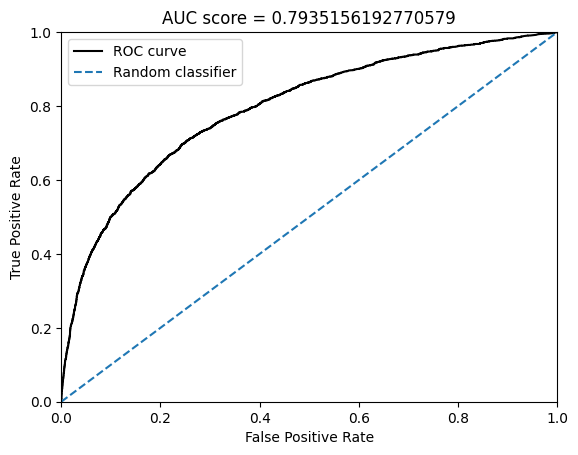

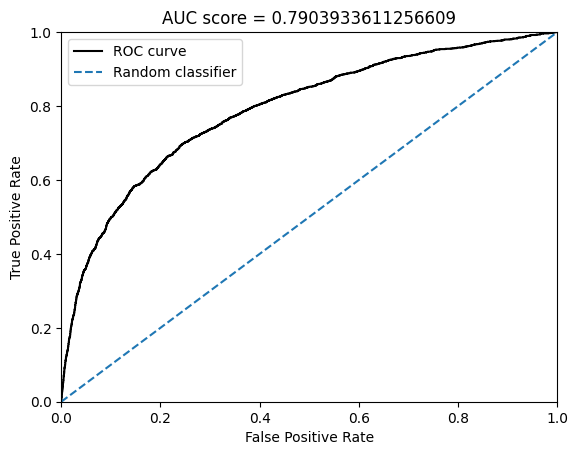

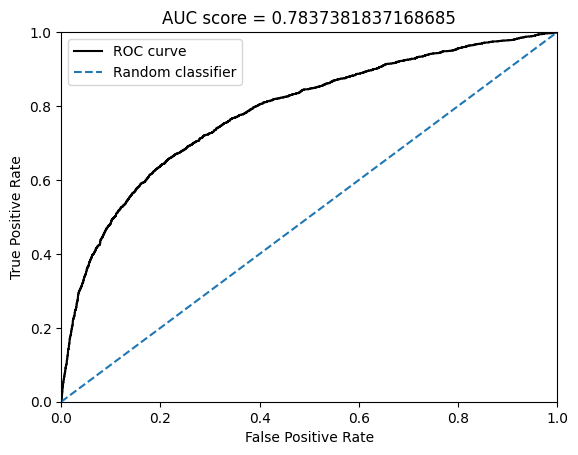

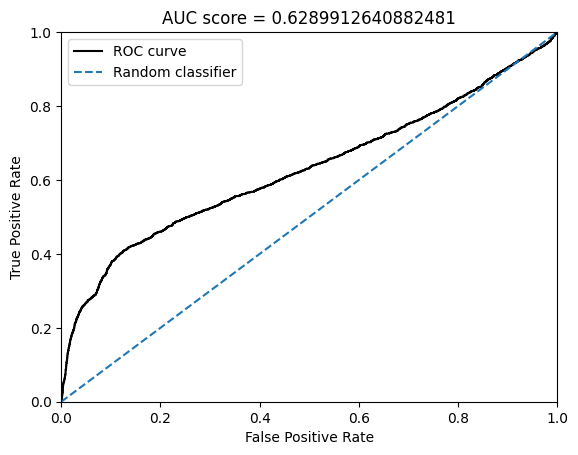

In [69]:
def plot_roc(val_y,pred_y):
    # Plot the ROC curve
    fpr, tpr, _ = roc_curve(val_y,pred_y, pos_label=1)

    plt.plot(fpr, tpr, 'k', label='ROC curve')

    # Plot the baseline
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random classifier')

    # Set the axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    # Set axis limits
    plt.xlim(0,1)
    plt.ylim(0,1)

    # Set the title
    plt.title('AUC score = ' + str(roc_auc_score(val_y,pred_y)))

    # Show the legend
    plt.legend()

    # Show the plot
    plt.show()
    
plot_roc(val_y,xgb_predictions)
plot_roc(val_y,random_forest_predictions)
plot_roc(val_y,extratree_classifier_predictions)
plot_roc(val_y,log_predictions)

## Final Prediction for test set

In [71]:
X_test = test_data.copy()
X_test = X_test #[reduced_features]

xgb_prediction = xgb_model.predict_proba(X_test)[:,1]
rf_predictions = rf_model.predict_proba(X_test)[:,1]
extratree_predictions = extratree_model.predict_proba(X_test)[:,1]


scaler = StandardScaler()
X_train = scaler.fit_transform(train_X)
X_test = scaler.transform(X_test)
n_components = 100  # You can adjust this based on your dataset and computational resources
nystroem = Nystroem(kernel='rbf', n_components=n_components, random_state=42)
X_train_nystroem = nystroem.fit_transform(X_train)
X_test_nystroem = nystroem.transform(X_test)
nystroem_logistic_predictions = nystroem_logistic_model.predict_proba(X_test_nystroem)[:,1]

final_prediction = nystroem_logistic_predictions

# Save predicted results to the competition submission format.
submission = pd.DataFrame({'id':test_data.index, 'defects':final_prediction})
submission = submission.set_index(keys="id")
submission.head(3)

submission.to_csv('submissions/11.nystroem_logistic_submission.csv')

## Valuable sources
- https://www.kaggle.com/competitions/playground-series-s3e23/discussion/445245
- https://www.kaggle.com/competitions/playground-series-s3e23/discussion/444685